In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
api_key = '6feb8c26f0ebddbc4a47b6cfeac77054'
url = f'https://api.stlouisfed.org/fred/series/observations?series_id=CCUSSP02CLM650N&api_key={api_key}&observation_start=1980-01-01&observation_end=2022-12-01&frequency=m&file_type=json'
response = requests.get(url)

In [3]:
json_data = response.json()

In [4]:
data = [(obs["date"], obs["value"]) for obs in json_data["observations"]]
df = pd.DataFrame(data, columns=["date", "Exchange Rate Chile"])
df["date"] = pd.to_datetime(df["date"])
df["Exchange Rate Chile"] = df["Exchange Rate Chile"].astype("float")
df.index = df["date"]
df = df.drop("date", axis = 1)
df.dropna()
df

,Exchange Rate Chile
date,
1980-01-01,39.00
1980-02-01,39.00
1980-03-01,39.00
1980-04-01,39.00
1980-05-01,39.00
...,...
2022-08-01,882.11
2022-09-01,966.00
2022-10-01,945.31


In [5]:
df.index.freq = "MS"

Text(0, 0.5, 'Exchange Rate (Percentage Older than 15)')

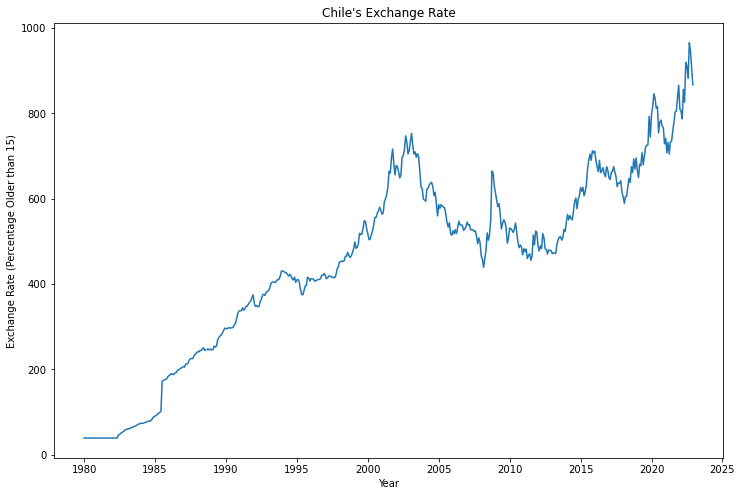

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(df['Exchange Rate Chile'])
plt.title("Chile's Exchange Rate")
plt.xlabel('Year')
plt.ylabel('Exchange Rate (Percentage Older than 15)')

In [7]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [8]:
adf_test(df['Exchange Rate Chile'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.957506
p-value                   0.768446
# lags used              11.000000
# observations          504.000000
critical value (1%)      -3.443392
critical value (5%)      -2.867292
critical value (10%)     -2.569833
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [9]:
len(df)

516

In [10]:
q_80 = int(len(df) * .8)

In [11]:
y_train = df["Exchange Rate Chile"].iloc[:q_80]
y_test = df["Exchange Rate Chile"].iloc[q_80:]

<AxesSubplot:xlabel='date'>

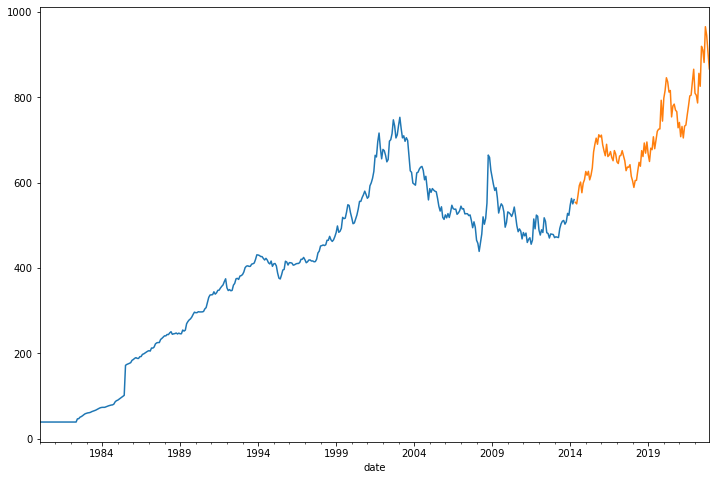

In [12]:
y_train.plot(figsize = (12, 8))
y_test.plot()

In [13]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
model = auto_arima(y_train, trace = True, seasonal = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3308.676, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3307.958, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3304.194, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3302.634, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3309.590, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=3300.634, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=3302.634, Time=0.17 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=3304.537, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3301.080, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=3300.581, Time=0.12 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=3302.577, Time=0.23 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=3302.576, Time=0.23 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=3304.476, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=3302.577, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0

Potential models are: 
- SARIMA(0,1,2)x(0,0,0,12)
- SARIMA(0,1,1)x(0,0,0,12)
- SARIMA(1,1,1)x(0,0,0,12)
- SARIMA(0,1,3)x(0,0,0,12)

In [15]:
model_list = {"order": [(0, 1, 2), (0, 1, 1), (1, 1 ,1), (0, 1 ,3)], "seasonal_order": [(0,0,0,12), (0,0,0,12), (0,0,0,12), (0,0,0,12)]}

In [16]:
from statsmodels.tools.eval_measures import rmse

In [17]:
metrics = pd.DataFrame(data = {"Order" : [], "Seasonal Order": [], "AIC": [], "BIC" : [], "RMSE": []})
for order, seasonal_order in zip(model_list["order"], model_list["seasonal_order"]):
    model= SARIMAX(y_train, order = order, seasonal_order = seasonal_order, enforce_invertibility = True, trend = "c").fit()
   
    start = len(y_train)
    end = len(y_train) + len(y_test) -1
    
    y_pred = model.predict(start, end)
    rmse_model = rmse(y_test, y_pred)
    
    metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)

C:\Users\User\AppData\Local\Temp\ipykernel_15548\2691938010.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)
C:\Users\User\AppData\Local\Temp\ipykernel_15548\2691938010.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC": model.aic, "BIC" : model.bic, "RMSE": rmse_model}, ignore_index = True)
C:\Users\User\AppData\Local\Temp\ipykernel_15548\2691938010.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append({"Order" : order, "Seasonal Order": seasonal_order, "AIC"

In [18]:
metrics = metrics.sort_values("RMSE")
metrics

,Order,Seasonal Order,AIC,BIC,RMSE
0,"(0, 1, 2)","(0, 0, 0, 12)",3300.581190,3316.655563,101.899227
3,"(0, 1, 3)","(0, 0, 0, 12)",3302.572069,3322.665035,101.911051
2,"(1, 1, 1)","(0, 0, 0, 12)",3301.080232,3317.154604,101.917170
1,"(0, 1, 1)","(0, 0, 0, 12)",3300.634007,3312.689786,101.969060


The best model is SARIMA(0,1,3)x(2,0,2,12)

<AxesSubplot:xlabel='date'>

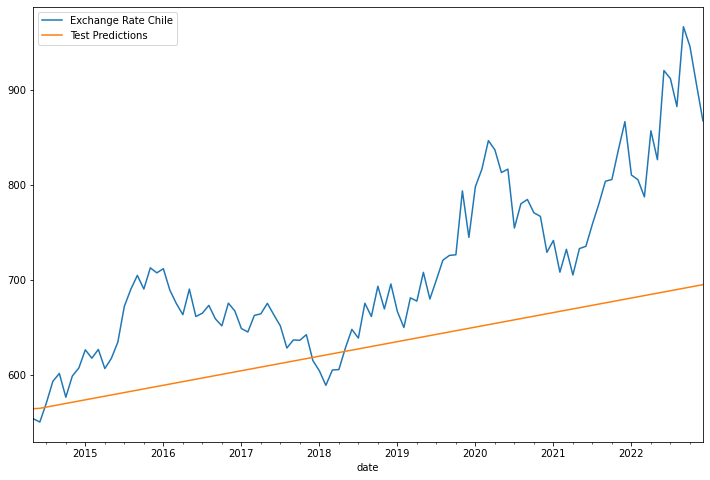

In [19]:
selected_model = SARIMAX(y_train, order = metrics["Order"].iloc[0], seasonal_order = metrics["Seasonal Order"].iloc[0], enforce_invertibility = True, trend = "c").fit()
y_hat_test = selected_model.predict(start, end).rename("Test Predictions")
plt.figure(figsize = (12, 8))
y_test.plot(legend = True)
y_hat_test.plot(legend = True)

In [20]:
final_model =  SARIMAX(df["Exchange Rate Chile"], order = metrics["Order"].iloc[0], seasonal_order = metrics["Seasonal Order"].iloc[0], enforce_invertibility = True, trend = "c").fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Exchange Rate Chile   No. Observations:                  516
Model:                SARIMAX(0, 1, 2)   Log Likelihood               -2189.640
Date:                 Fri, 02 Jun 2023   AIC                           4387.280
Time:                         01:21:57   BIC                           4404.256
Sample:                     01-01-1980   HQIC                          4393.933
                          - 12-01-2022                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6210      0.807      2.008      0.045       0.039       3.203
ma.L1         -0.0723      0.031     -2.316      0.021      -0.133      -0.011
ma.L2          0.0575      0.027      2.142      0.032       0.005       0.110
sigma2       288.6986      9.059     31.868      0.000     270.943     306.454
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1190.36
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              14.69   Skew:                             1.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
forecast_size = 12

In [22]:
final_order  = metrics["Order"].iloc[0]
final_seasonal_order = metrics["Seasonal Order"].iloc[0]

In [23]:
y_forecast = final_model.predict(start = len(df), end = len(df) + forecast_size - 1, typ = "levels").rename(f"SARIMA{final_order}x{final_seasonal_order} Forecast")

<AxesSubplot:xlabel='date'>

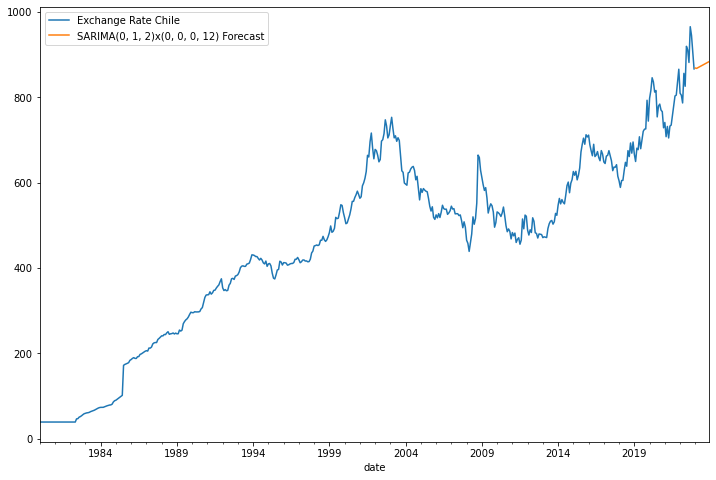

In [24]:
plt.figure(figsize = (12, 8))
df["Exchange Rate Chile"].plot(legend = True)
y_forecast.plot(legend = True)

<AxesSubplot:xlabel='date'>

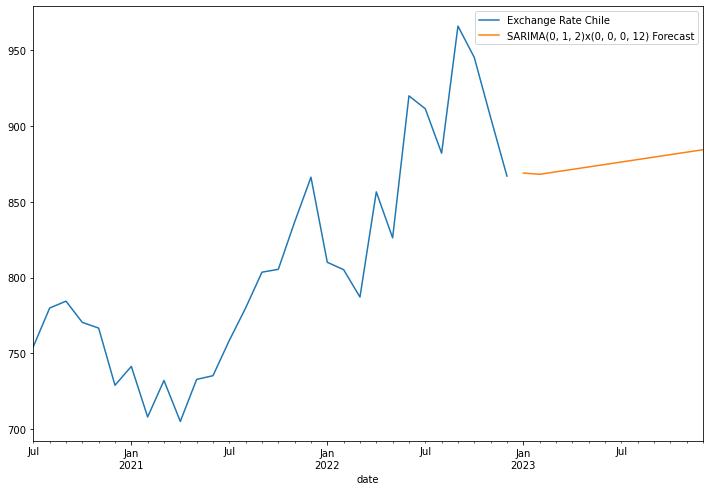

In [25]:
plt.figure(figsize = (12, 8))
df["Exchange Rate Chile"].iloc[-30:].plot(legend = True)
y_forecast.plot(legend = True)

In [26]:
y_forecast

2023-01-01    869.031490
2023-02-01    868.186298
2023-03-01    869.807326
2023-04-01    871.428354
2023-05-01    873.049382
2023-06-01    874.670410
2023-07-01    876.291438
2023-08-01    877.912466
2023-09-01    879.533494
2023-10-01    881.154522
2023-11-01    882.775550
2023-12-01    884.396578
Freq: MS, Name: SARIMA(0, 1, 2)x(0, 0, 0, 12) Forecast, dtype: float64